<h1 style="property:value; background-color:skyblue;" align="center"> Data preparation and imputaion

In [1]:
# Basic libraries
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# utils unctions
from impute_utils import nrmse, evaluate, imputation

# GAIN utility functions
from GAIN.GAIN import GAIN
from GAIN.utils import show_results as show_results_gain, data_preprocessor as data_preprocessor_gain

# Conv GAIN utility function
from Conv_GAIN.ConvGAIN import Conv_GAIN
from Conv_GAIN.utils import show_results as show_results_conv_gain, data_preprocessor as data_preprocessor_conv_gain

Instructions for updating:
non-resource variables are not supported in the long term


### After gathering and preparing the data :
- Read the text files as csv.
- Concatinate all the data in one DataFrame.
- Resampling the whole data.
- Groupe the data by time and grid.
- Convevrt the full data into a numpy array, where each sample is a (100, 100) matrix.
 - Each matrix is the measurements for all grids at a spicific time step.
 - Each value in the matrix is a measurement for one grid at a this time step.
 
 
 Now we are going to deal with the final numpy data.

In [2]:
# Dealing with the data after gathering and resampling
path = r''
full_data = np.load(r'{}\full_millan_time_grid.npy'.format(path), allow_pickle=True)
month_1 = full_data[:144*30,...]
month_2 = full_data[144*30:,...]

### Show some example of the data

#### Line plot for some grids over time.

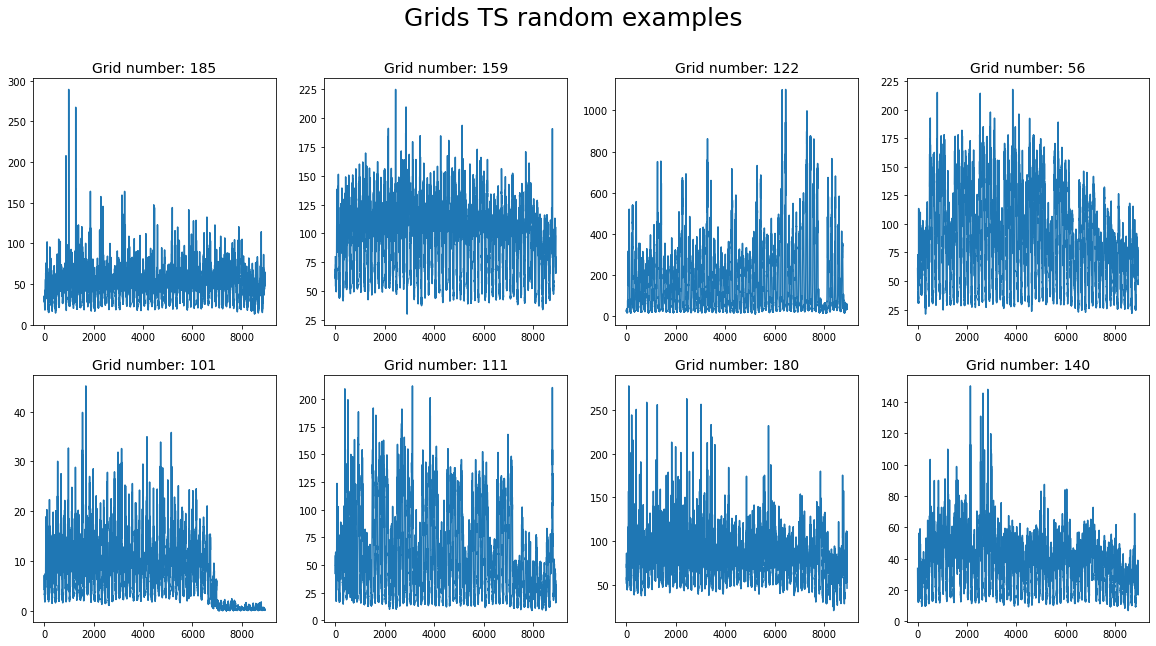

In [3]:
r, c = 2, 4
fig = plt.figure(figsize=(20,10))
fig.suptitle('Grids TS random examples', fontsize=25)

for i in range(r*c):
    x = np.random.randint(0, full_data.shape[1])
    y = np.random.randint(0, full_data.shape[2])
    plt.subplot(r, c, i+1)
    plt.title('Grid number: %d'%int(x+y), fontsize = 14)
    plt.plot(full_data[:,x,y,:]);

#### Full grids measurements at time steps.

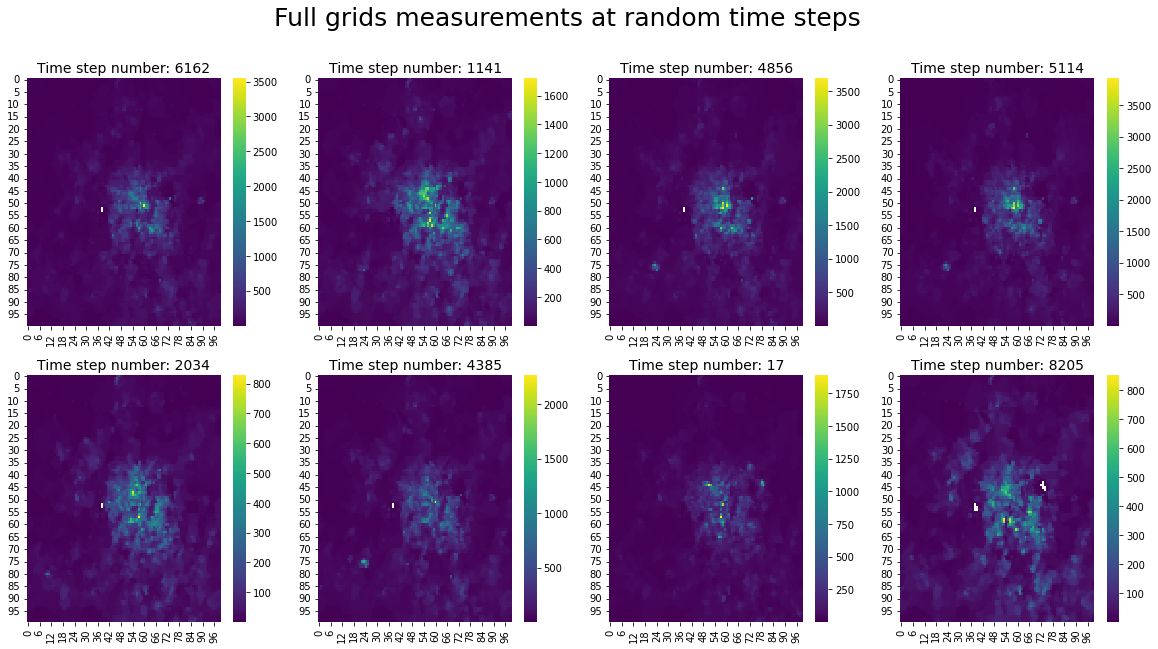

In [4]:
fig = plt.figure(figsize=(20,10))
fig.suptitle('Full grids measurements at random time steps', fontsize=25)

for i in range(r*c):
    s = np.random.randint(0, len(full_data))
    plt.subplot(r, c, i+1)
    plt.title('Time step number: %d'%s, fontsize = 14)
    sns.heatmap(full_data[s].reshape(100, 100), cmap='viridis')

#### NaN values in the data

In [5]:
nan_ratio_full = (np.isnan(full_data).sum()/len(full_data.flatten()))
print('NaN values ratio in the full data is : %f'%nan_ratio_full,'%')

NaN values ratio in the full data is : 0.000388 %


In [6]:
nan_ratio_1 = (np.isnan(month_1).sum()/len(full_data.flatten()))
print('NaN values ratio is : %f'%nan_ratio_1,'%')

NaN values ratio is : 0.000031 %


In [7]:
nan_ratio_2 = (np.isnan(month_2).sum()/len(full_data.flatten()))
print('NaN values ratio is : %f'%nan_ratio_2,'%')

NaN values ratio is : 0.000358 %


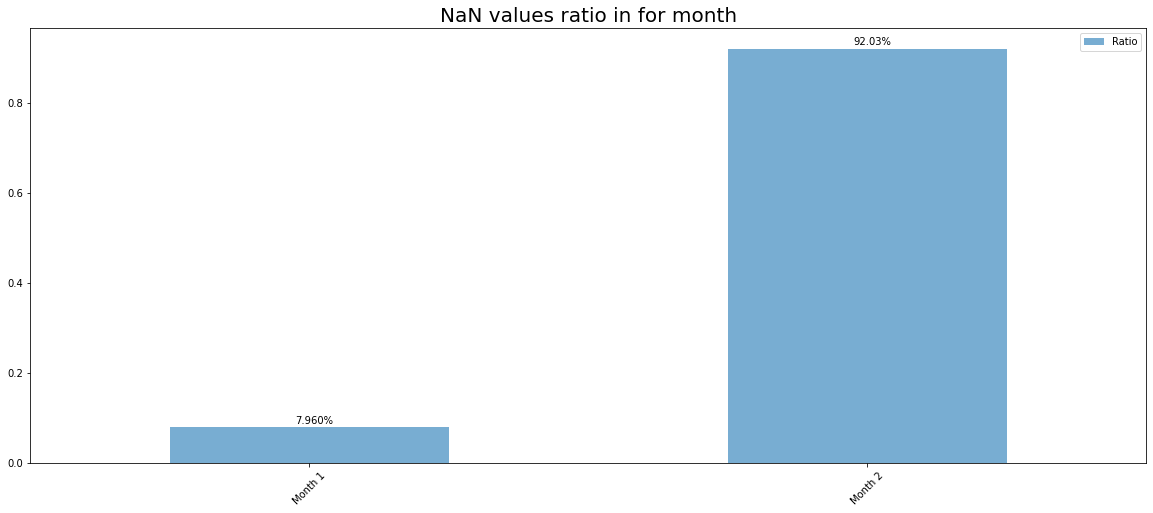

In [8]:
# create a dataframe of NaN ratios
nan_df = pd.DataFrame(data={'Month 1':nan_ratio_1/nan_ratio_full, 
                            'Month 2':nan_ratio_2/nan_ratio_full}, 
                      index=['Ratio']).T
# create a bar plot
ax = nan_df.plot(kind='bar', rot=45, alpha=0.6, figsize=(20, 8))
ax.set_title('NaN values ratio in for month', fontsize=20)
ax.annotate(str(str(ax.patches[0].get_height()*100)[:5]+'%'), (ax.patches[0].get_x()* 0.1, ax.patches[0].get_height()* 1.1))
ax.annotate(str(str(ax.patches[1].get_height()*100)[:5]+'%'), (ax.patches[1].get_x()* 1.3, ax.patches[1].get_height()* 1.01));

><b>Most of Null values in month 2. (92%), so we can work with month 1 to be able to evaluate our results.<br>
> I will work with the month one data and neglect this small ratio, then compare the performace of each imputation model with

#### Steps:
- Add synthesized NaN values with ratios (5%, 10%, 15%, 20%,
and 25%).
- Apply all methods for all grids with all of these ratios.
- Evaluate the performance of each method for all ratios using the NRMSE evaluation metrics.
- Compare different methods and decide which one to use.  

In [13]:
# We will deal with a reduced version of the data.
na_1 = np.isnan(month_1).sum()
# Use a new 40x40 grids instead of 100x100
na_2 = np.isnan(data_preprocessor_conv_gain(month_1, 40, 40)).sum()
print('NaN values in month 1: {}\nNan values in reduced version: {}'.format(na_1, na_2))

NaN values in month 1: 2761
Nan values in reduced version: 2069


><b>The (40 x 40) verson still has the most of nan value and also can be maintained easier by many algorithms to make comparison.

### Missing data imputation models
- We have several methods to impute time series data 
    - Conventional methods:
        - Ignore or deletion.
        - Mean imputation.
        - Mode imputation.
        - Median imputation.
    - Imputation procedure:
        - Last valid observation forward.
        - Next valid observation forward.
        - Interpolation.
    - Learnable methods:
        - KNN algorithm.
        - AutoRegressive.
        - Genitic algorithm.
        - MICE algorithm.
        - Least square SVM.
        - GAIN.
        - Conv-GAIN.
        
        
**But simply imputing the overall mean, median or mode to replace the NaN values is not a good idea with the complex seasonlaities.**

## Conventional methods

### 1) Mean

In [14]:
Mean_Results = {'5%':None, '10%':None, '15%':None, '20%':None, '25%':None}
bar = tqdm(Mean_Results.keys())

for ratio in bar:
    miss_rate = int(ratio[:-1])/100
    data_x, miss_data_x, data_m = data_preprocessor_gain(data=month_1, x_dim=40, y_dim=40, miss_rate=miss_rate)
    data_x, miss_data_x, data_m = data_x.reshape(-1, 40, 40), miss_data_x.reshape(-1, 40, 40), data_m.reshape(-1, 40, 40)
    Mean_Results[ratio] = {ratio: value for ratio, value in imputation(data_x, miss_data_x, data_m, 'mean').items()}
    bar.set_description(f'{ratio} is Done!')

25% is Done!: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.38s/it]


In [15]:
Mean_Results = pd.DataFrame(Mean_Results).T
Mean_Results

,nrmse
5%,0.012955
10%,0.018343
15%,0.022433
20%,0.025931
25%,0.029002


### 2) Mode

In [17]:
Mode_Results = {'5%':None, '10%':None, '15%':None, '20%':None, '25%':None}
bar = tqdm(Mode_Results.keys())

for ratio in bar:
    miss_rate = int(ratio[:-1])/100
    data_x, miss_data_x, data_m = data_preprocessor_gain(data=month_1, miss_rate=miss_rate, x_dim=40, y_dim=40)
    data_x, miss_data_x, data_m = data_x.reshape(-1, 40, 40), miss_data_x.reshape(-1, 40, 40), data_m.reshape(-1, 40, 40)
    Mode_Results[ratio] = {ratio: value for ratio, value in imputation(data_x, miss_data_x, data_m, 'mode').items()}
    bar.set_description(f'{ratio} is Done!')

25% is Done!: 100%|██████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.86s/it]


In [18]:
Mode_Results = pd.DataFrame(Mode_Results).T
Mode_Results

,nrmse
5%,0.021222
10%,0.029974
15%,0.037260
20%,0.043481
25%,0.049128


### 3) Median

In [19]:
Median_Results = {'5%':None, '10%':None, '15%':None, '20%':None, '25%':None}
bar = tqdm(Median_Results.keys())

for ratio in bar:
    miss_rate = int(ratio[:-1])/100
    data_x, miss_data_x, data_m = data_preprocessor_gain(data=month_1, miss_rate=miss_rate, x_dim=40, y_dim=40)
    data_x, miss_data_x, data_m = data_x.reshape(-1, 40, 40), miss_data_x.reshape(-1, 40, 40), data_m.reshape(-1, 40, 40)
    Median_Results[ratio] = {ratio: value for ratio, value in imputation(data_x, miss_data_x, data_m, 'median').items()}
    bar.set_description(f'{ratio} is Done !')

25% is Done !: 100%|█████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.25s/it]


In [20]:
Median_Results = pd.DataFrame(Median_Results).T
Median_Results

,nrmse
5%,0.013309
10%,0.018788
15%,0.023012
20%,0.026603
25%,0.029812


#### Compare all imputaion conventional methods

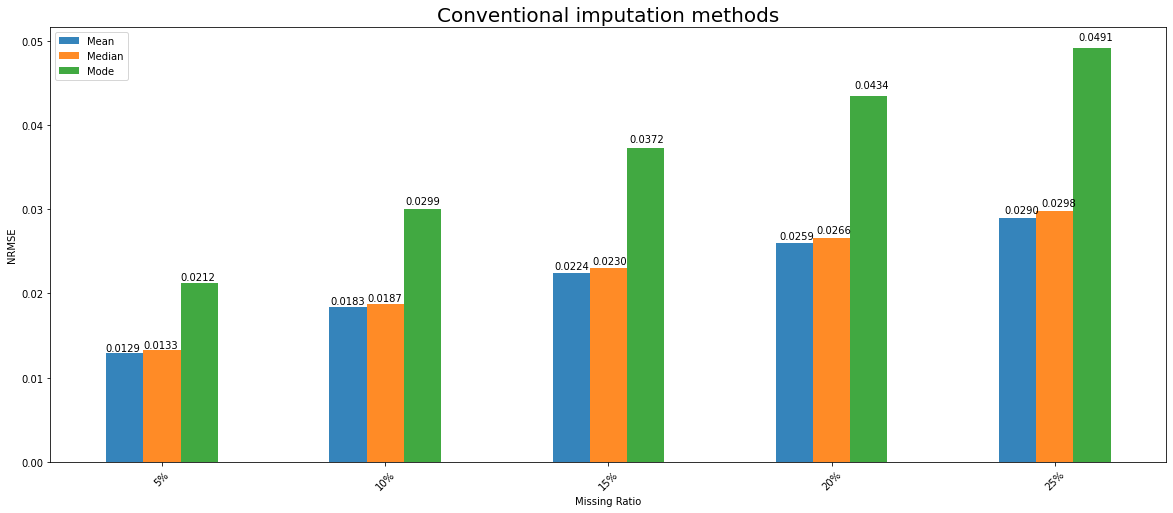

In [21]:
# Concatenate all results in one dataframe
full_conven_results = Mean_Results.rename(columns={'nrmse':'Mean'})
full_conven_results['Median'] = Median_Results
full_conven_results['Mode'] = Mode_Results

ax = full_conven_results.plot(kind='bar', rot=45, alpha=0.9, figsize=(20,8))
ax.set_title('Conventional imputation methods', fontsize=20)
ax.set_xlabel('Missing Ratio')
ax.set_ylabel('NRMSE');
for p in ax.patches:
    ax.annotate(str(str(p.get_height())[:6]), (p.get_x()* 1.006, p.get_height()* 1.02))

## Imputaion procedure

### 1) Last valid observation

In [22]:
Lvo_Results = {'5%':None, '10%':None, '15%':None, '20%':None, '25%':None}
Nvo_Results = {'5%':None, '10%':None, '15%':None, '20%':None, '25%':None}
bar = tqdm(Lvo_Results.keys())

for ratio in bar:        
    miss_rate = int(ratio[:-1])/100
    data_x, miss_data_x, data_m = data_preprocessor_gain(data=month_1, miss_rate=miss_rate, x_dim=40, y_dim=40)
    data_x, miss_data_x, data_m = data_x.reshape(-1, 40, 40), miss_data_x.reshape(-1, 40, 40), data_m.reshape(-1, 40, 40)
    Lvo_Results[ratio] = imputation(data_x, miss_data_x, data_m, 'LVO')
    bar.set_description(f'{ratio} is Done !')

25% is Done !: 100%|█████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.97s/it]


In [23]:
Lvo_Results = pd.DataFrame(Lvo_Results).T
Lvo_Results

,nrmse
5%,0.004573
10%,0.006545
15%,0.008101
20%,0.009437
25%,0.010690


### 2) Next valid observation

In [24]:
Nvo_Results = {'5%':None, '10%':None, '15%':None, '20%':None, '25%':None}
bar = tqdm(Nvo_Results.keys())

for ratio in bar:        
    miss_rate = int(ratio[:-1])/100
    data_x, miss_data_x, data_m = data_preprocessor_gain(data=month_1, miss_rate=miss_rate, x_dim=40, y_dim=40)
    data_x, miss_data_x, data_m = data_x.reshape(-1, 40, 40), miss_data_x.reshape(-1, 40, 40), data_m.reshape(-1, 40, 40)
    Nvo_Results[ratio] = imputation(data_x, miss_data_x, data_m, 'NVO')
    bar.set_description(f'{ratio} is Done !')

25% is Done !: 100%|█████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.74s/it]


In [25]:
Nvo_Results = pd.DataFrame(Nvo_Results).T
Nvo_Results

,nrmse
5%,0.004577
10%,0.006525
15%,0.008122
20%,0.009443
25%,0.010689


### 3) Interpolation

In [26]:
Interpolation_Results = {'5%':None, '10%':None, '15%':None, '20%':None, '25%':None}
bar = tqdm(Interpolation_Results.keys())

for ratio in bar:
    miss_rate = int(ratio[:-1])/100
    data_x, miss_data_x, data_m = data_preprocessor_gain(data=month_1, miss_rate=miss_rate, x_dim=40, y_dim=40)
    data_x, miss_data_x, data_m = data_x.reshape(-1, 40, 40), miss_data_x.reshape(-1, 40, 40), data_m.reshape(-1, 40, 40)
    Interpolation_Results[ratio] = {ratio: value for ratio, value in \
                                    imputation(data_x, miss_data_x, data_m, 'inter').items()}
    bar.set_description(f'{ratio} is Done !')

25% is Done !: 100%|█████████████████████████████████████████████████████████████████████| 5/5 [04:45<00:00, 57.03s/it]


In [27]:
Interpolation_Results = pd.DataFrame(Interpolation_Results).T
Interpolation_Results

,nrmse
5%,0.004849
10%,0.006961
15%,0.008672
20%,0.010172
25%,0.011572


#### Compare all imputaion procedure methods

In [28]:
# Concatenate all results in one dataframe
full_proc_results = Lvo_Results.rename(columns={'nrmse':'Last valid observation'})
full_proc_results['Next valid observation'] = Nvo_Results
full_proc_results['Interpolation'] = Interpolation_Results

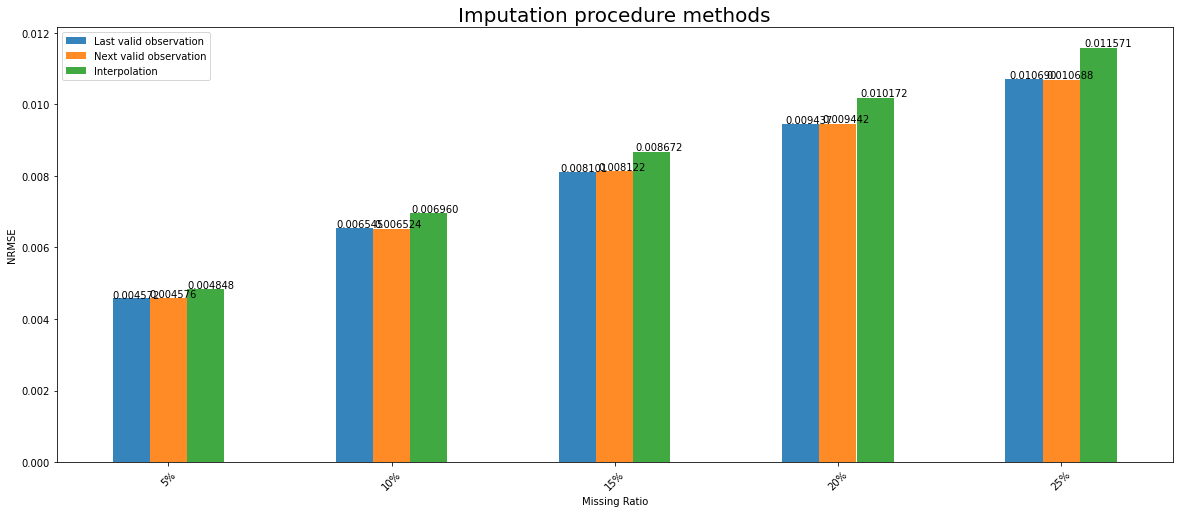

In [29]:
# Concatenate all results in one dataframe
ax = full_proc_results.plot(kind='bar', rot=45, alpha=0.9, figsize=(20,8));
ax.set_title('Imputation procedure methods', fontsize=20)
ax.set_xlabel('Missing Ratio')
ax.set_ylabel('NRMSE');
for p in ax.patches:
    ax.annotate(str(str(p.get_height())[:8]), (p.get_x()* 1.005, p.get_height()* 1.005))

### Conventional vs. Procedure methods

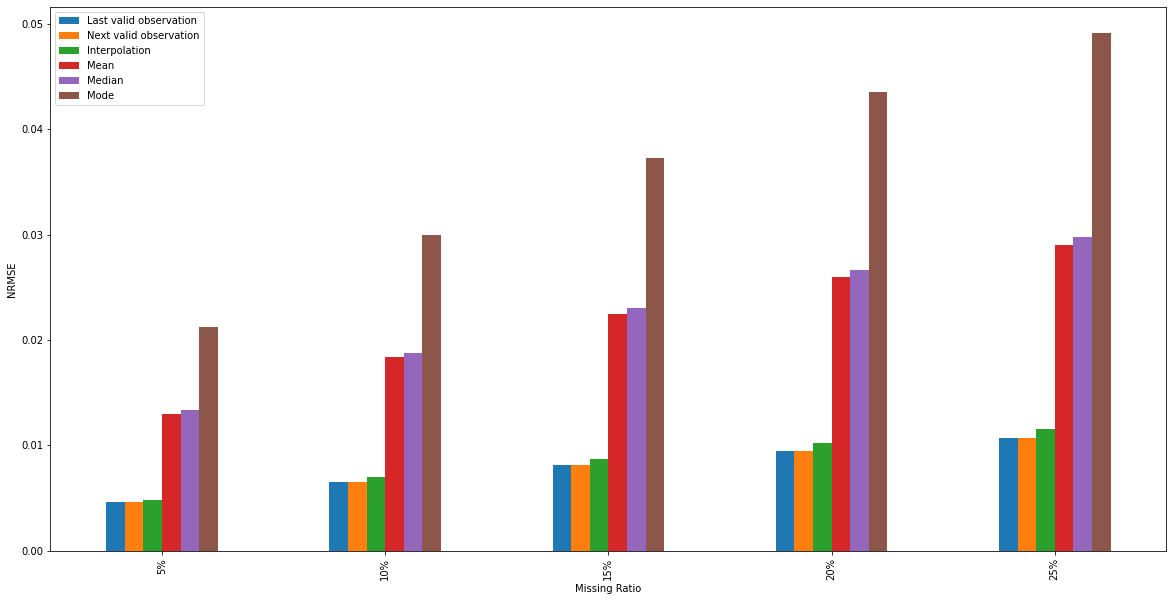

In [30]:
full_results = full_conven_results
full_results.to_csv('Con_Proc.csv')
full_results['Next valid observation'] = Nvo_Results
full_results['Last valid observation'] = Lvo_Results
full_results['Interpolation'] = Interpolation_Results
ax = full_results.T.sort_values('5%', ascending=True).T.plot(kind='bar', figsize=(20, 10), style='.-')
# for p in ax.patches:
#     ax.annotate(str(str(p.get_height())[:5]), (p.get_x()* 1.005, p.get_height()* 1.005))
ax.set_xlabel('Missing Ratio')
ax.set_ylabel('NRMSE');

## Learnable methods

### 1) MICE (Multiple imputation using chained equations)

<h3 align='center'>Example of MICE </h3><br>
<img src="images\MICE.png" height="800" width="800">

In [31]:
MICE_Results = {'5%':None, '10%':None, '15%':None, '20%':None, '25%':None}
bar = tqdm(MICE_Results.keys())
    
for ratio in bar: 
    miss_rate = int(ratio[:-1])/100
    data_x, miss_data_x, data_m = data_preprocessor_conv_gain(data=month_1, miss_rate=miss_rate, x_dim=40, y_dim=40)
    data_x, miss_data_x, data_m = data_x.reshape(-1, 40, 40), miss_data_x.reshape(-1, 40, 40), data_m.reshape(-1, 40, 40)
    MICE_Results[ratio] = imputation(data_x, miss_data_x, data_m, 'mice', max_iter=2)
    bar.set_description(f'{ratio} is Done !')

25% is Done !: 100%|█████████████████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.56it/s]


In [32]:
MICE_Results = pd.DataFrame(index = MICE_Results.keys(), data = MICE_Results.values()).rename(columns={0:'MICE'})
MICE_Results

,MICE
5%,0.000281
10%,0.000405
15%,0.000492
20%,0.000565
25%,0.000635


### GAIN
<a href="https://arxiv.org/abs/1806.02920">Paper Link</a>

Miss Ratio: 5%


Epoch(1): D_loss, G_loss ===> 0.203, 0.003: 100%|██████████████████████████████████████| 67/67 [00:21<00:00,  3.10it/s]


Image : 96
nrmse :  0.006611520385006978


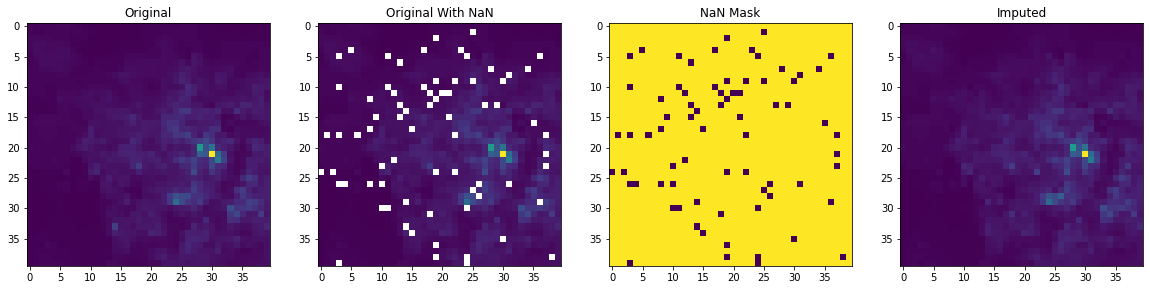

Image : 2429
nrmse :  0.019542920476824585


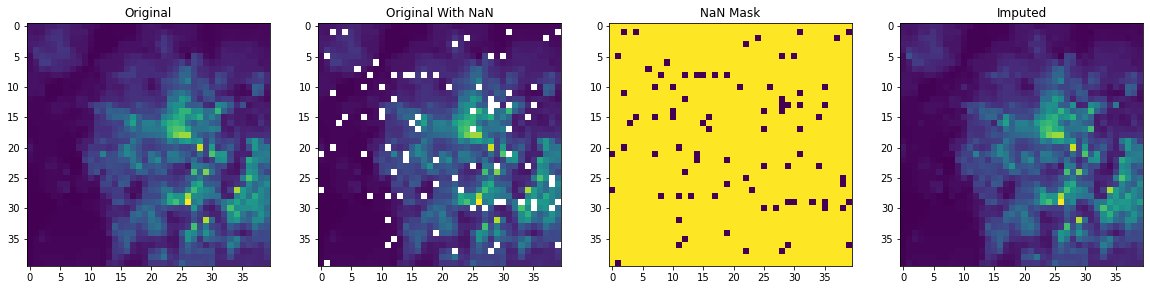

Miss Ratio: 10%


Epoch(1): D_loss, G_loss ===> 0.325, 0.011: 100%|██████████████████████████████████████| 67/67 [00:18<00:00,  3.54it/s]


Image : 192
nrmse :  0.3988369521541761


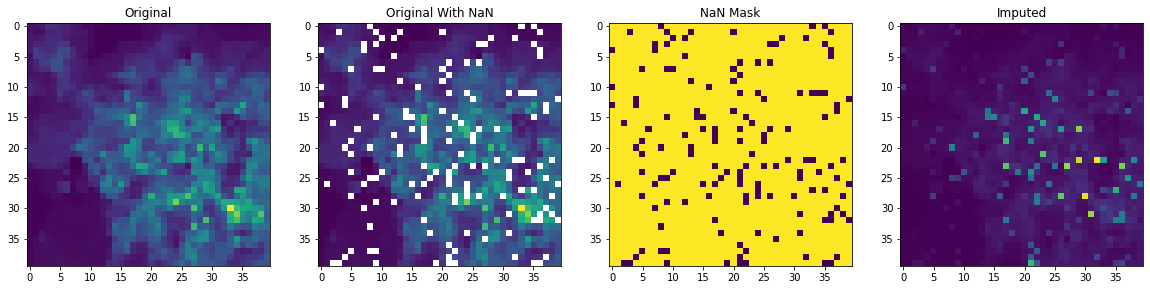

Image : 1783
nrmse :  0.049985954177420466


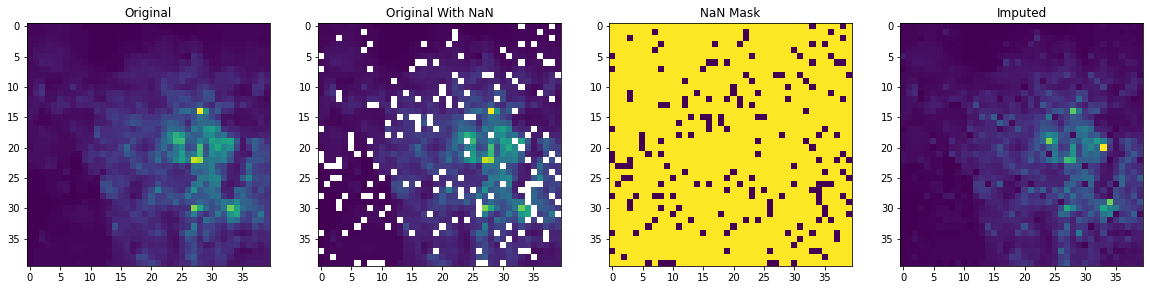

Miss Ratio: 15%


Epoch(1): D_loss, G_loss ===> 0.427, 0.024: 100%|██████████████████████████████████████| 67/67 [00:20<00:00,  3.32it/s]


Image : 1920
nrmse :  0.15635050931673466


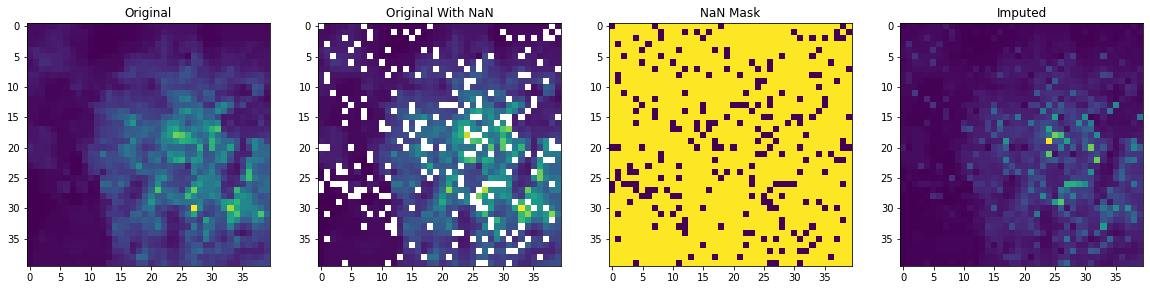

Image : 3361
nrmse :  0.4346409783298795


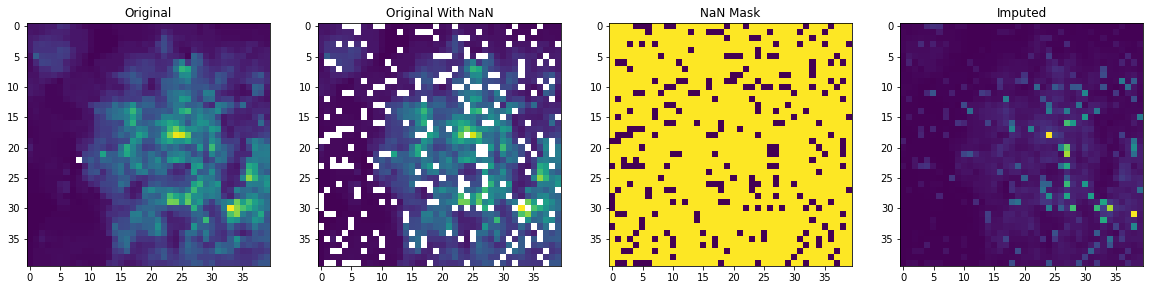

Miss Ratio: 20%


Epoch(1): D_loss, G_loss ===> 0.501, 0.044: 100%|██████████████████████████████████████| 67/67 [00:19<00:00,  3.48it/s]


Image : 3260
nrmse :  0.0645421630589889


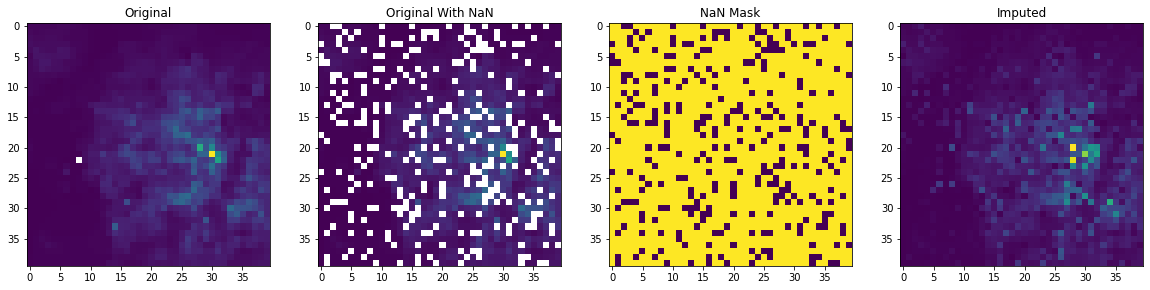

Image : 2048
nrmse :  0.6896859939848278


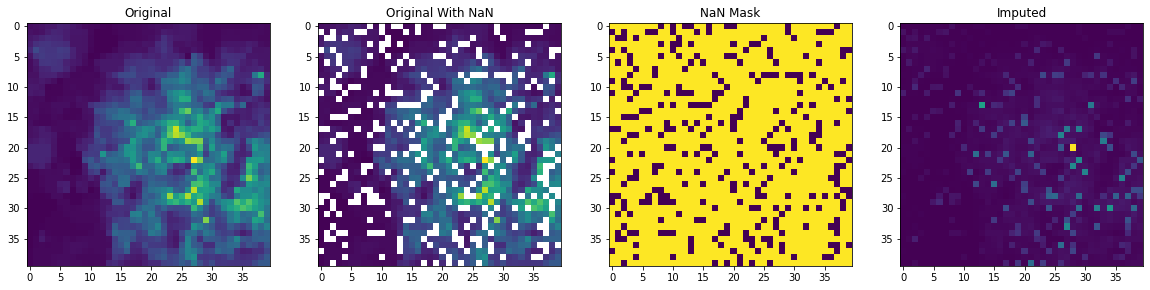

Miss Ratio: 25%


Epoch(1): D_loss, G_loss ===> 0.563, 0.074: 100%|██████████████████████████████████████| 67/67 [00:19<00:00,  3.51it/s]


Image : 1044
nrmse :  0.4021476459636187


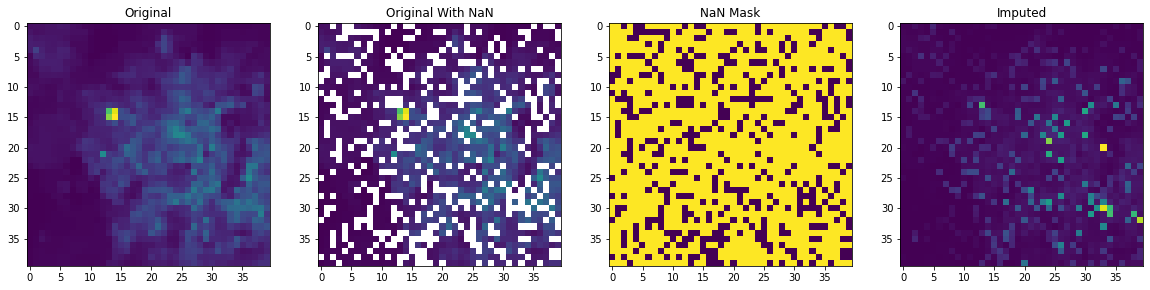

Image : 2738
nrmse :  0.2178512009919398


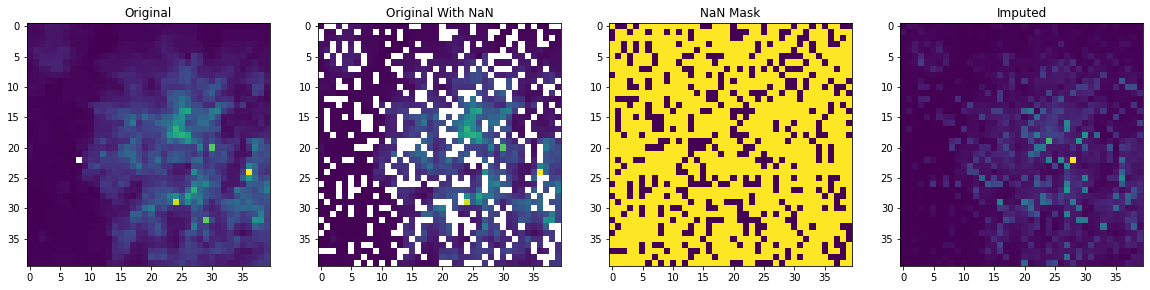

In [34]:
GAIN_Results ={'5%':None, '10%':None, '15%':None, '20%':None, '25%':None}
gain_parameters = {'batch_size':64,
                   'hint_rate':0.1,
                   'learning_rate':0.001,
                   'alpha':0.005,
                   'iterations':1}

# apply the gain algorithms for all ratio and show two random samples after & before imputation
for ratio in GAIN_Results.keys():
    miss_rate = int(ratio[:-1])/100
    data_x, miss_data_x, data_m = data_preprocessor_gain(month_1, miss_rate, 40, 40)
    print('Miss Ratio: %s'%ratio)
    imputed_data = GAIN(miss_data_x, gain_parameters)
    show_results_gain(data_x, miss_data_x, data_m, imputed_data, num_examples=2, cmap='viridis')
    GAIN_Results[ratio] = evaluate(actual=data_x, predicted=imputed_data, mask=data_m, metrics=(['nrmse']))

In [35]:
GAIN_res = pd.DataFrame(GAIN_Results).T.rename(columns={'nrmse':'GAIN'})
GAIN_res

,GAIN
5%,0.000007
10%,0.000056
15%,0.000047
20%,0.000052
25%,0.000064


### Conv-GAIN
- Performance is improved by applying convolutional neural networks instead of fully connected layers to better capture the correlation of data and promote learning from the adjacent surge points.<br>
- <a href="https://arxiv.org/abs/2111.02823">Paper Link</a><br>
- <a href="https://github.com/AlaaSedeeq/Convolutional-GAIN">My implementation of the research paper</a>

Miss Ratio: 5%


Epoch(1): D_loss, G_loss ===> 2.331, 0.079: 100%|██████████████████████████████████████| 67/67 [02:39<00:00,  2.38s/it]


Image : 3314
nrmse :  0.034127419066312954


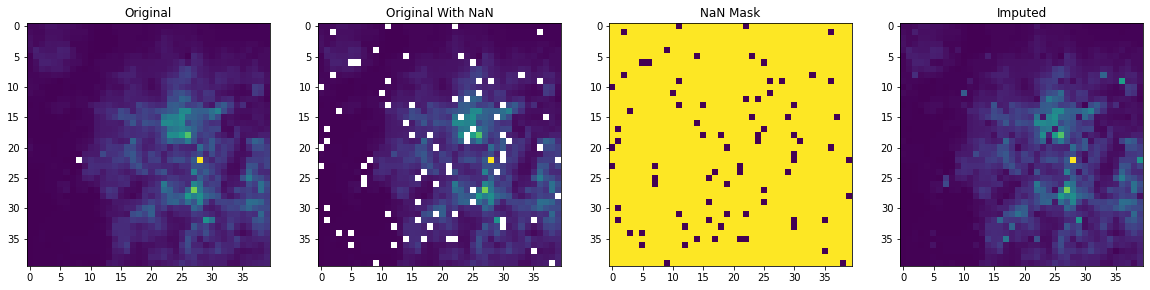

Image : 113
nrmse :  0.03856775265069999


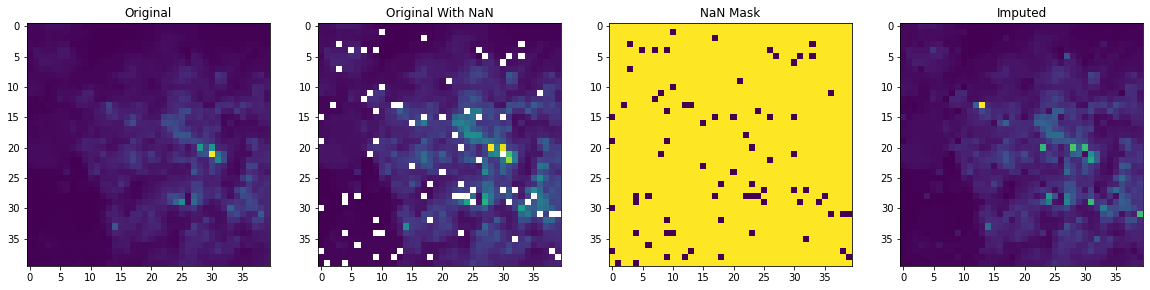

Miss Ratio: 10%


Epoch(1): D_loss, G_loss ===> 3.836, 0.263: 100%|██████████████████████████████████████| 67/67 [02:46<00:00,  2.48s/it]


Image : 132
nrmse :  0.1160362005647216


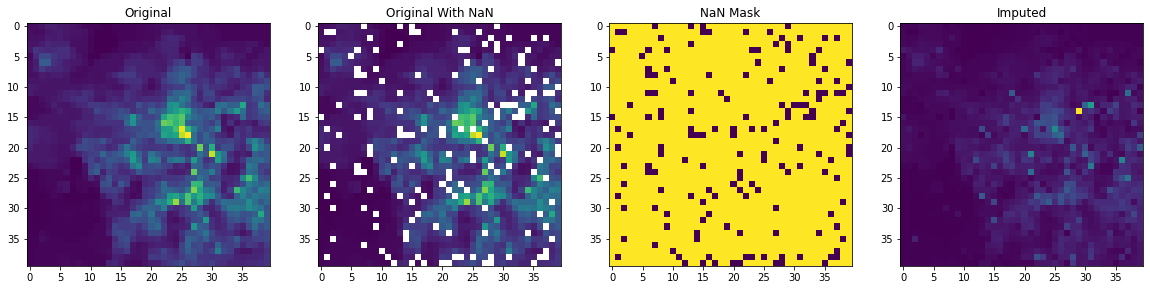

Image : 792
nrmse :  0.04635990164304871


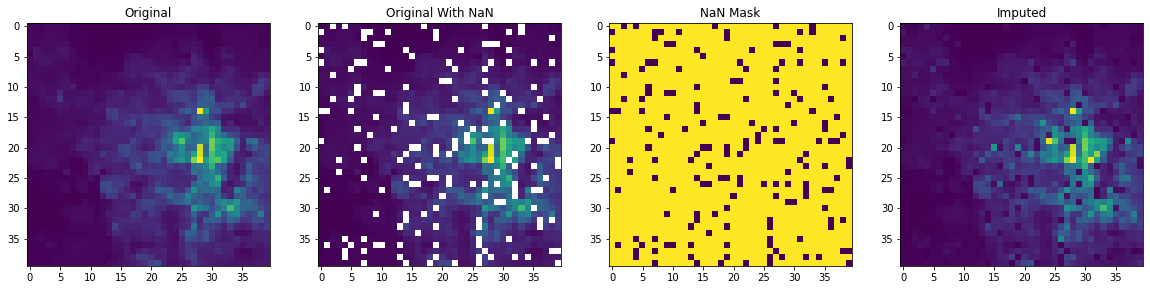

Miss Ratio: 15%


Epoch(1): D_loss, G_loss ===> 4.863, 0.431: 100%|██████████████████████████████████████| 67/67 [02:38<00:00,  2.37s/it]


Image : 1094
nrmse :  0.045365908671938494


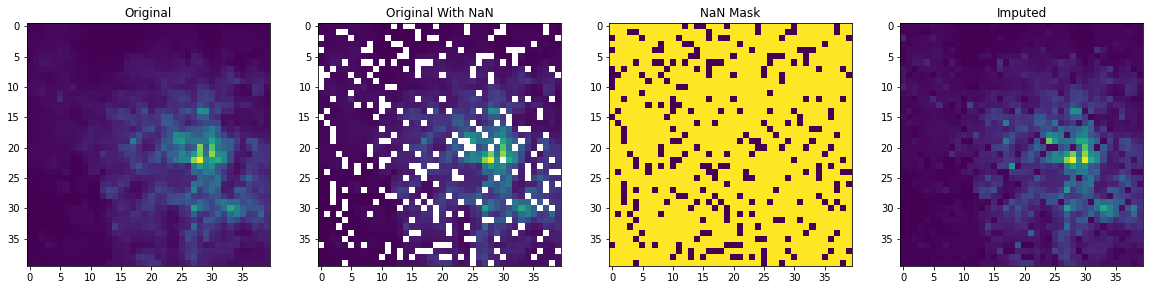

Image : 3578
nrmse :  0.09540032665862734


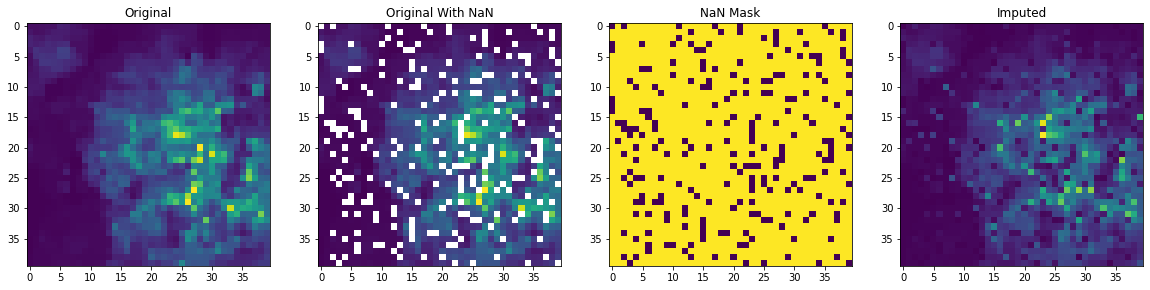

Miss Ratio: 20%


Epoch(1): D_loss, G_loss ===> 6.118, 0.829: 100%|██████████████████████████████████████| 67/67 [02:38<00:00,  2.37s/it]


Image : 2544
nrmse :  0.06042388209730099


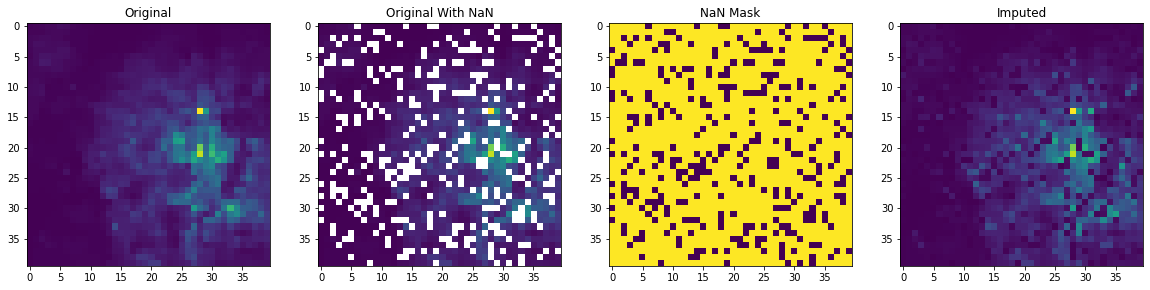

Image : 1752
nrmse :  0.3710448491253884


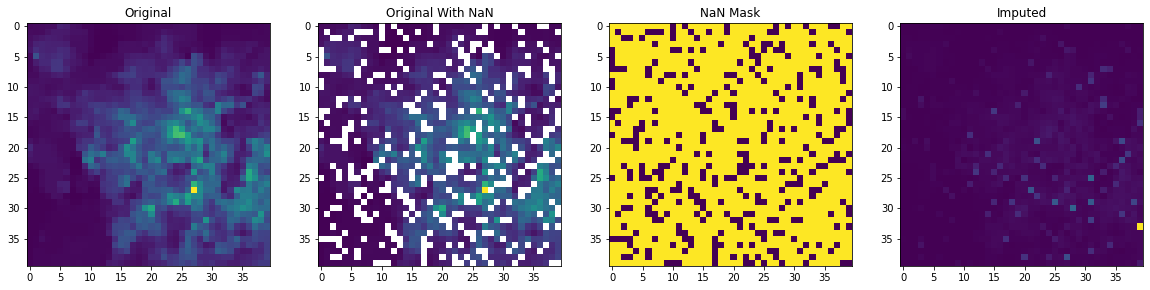

Miss Ratio: 25%


Epoch(1): D_loss, G_loss ===> 7.107, 1.282: 100%|██████████████████████████████████████| 67/67 [02:40<00:00,  2.39s/it]


Image : 3799
nrmse :  0.08718405277658625


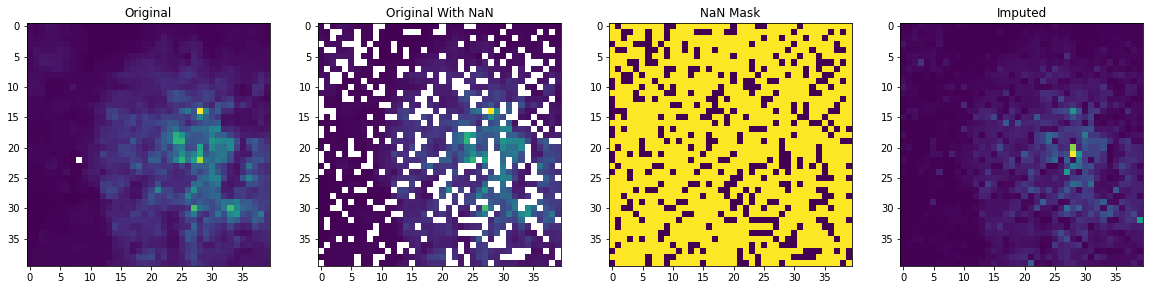

Image : 1560
nrmse :  0.13745077806697048


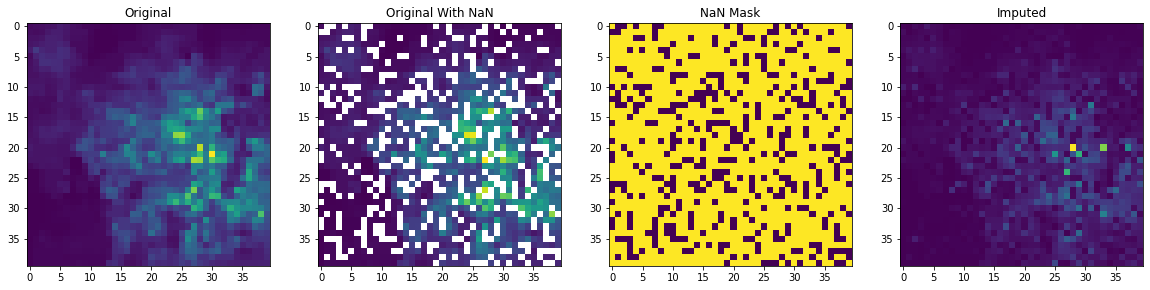

In [46]:
Conv_GAIN_Results = {'5%':None, '10%':None, '15%':None, '20%':None, '25%':None}
conv_gain_parameters = {'batch_size':64,
                        'hint_rate':0.1,
                        'learning_rate':0.001,
                        'alpha':0.005,
                        'iterations':1}

# apply the gain algorithms for all ratio and show two random samples after & before imputation
for ratio in Conv_GAIN_Results.keys():
    miss_rate = int(ratio[:-1])/100
    data_x, miss_data_x, data_m = data_preprocessor_conv_gain(month_1, 40, 40, miss_rate)
    print('Miss Ratio: %s'%ratio)
    imputed_data = Conv_GAIN(miss_data_x, conv_gain_parameters)
    show_results_conv_gain(data_x, miss_data_x, data_m, imputed_data, num_examples=2, cmap='viridis')
    Conv_GAIN_Results[ratio] = evaluate(actual=data_x, predicted=imputed_data, mask=data_m, metrics=(['nrmse']))

In [47]:
Conv_Gain_res = pd.DataFrame(Conv_GAIN_Results).T.rename(columns={'nrmse':'Conv-GAIN'})
Conv_Gain_res

,Conv-GAIN
5%,0.000025
10%,0.000025
15%,0.000035
20%,0.000038
25%,0.000045


#### GAIN vs Conv-GAIN

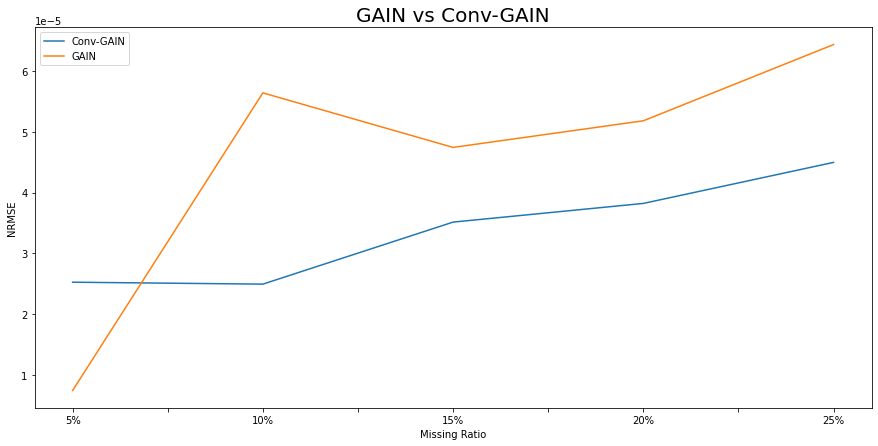

In [48]:
g_r = pd.DataFrame(Conv_GAIN_Results).T.rename(columns={'nrmse':'Conv-GAIN'})
g_r['GAIN'] = [list(GAIN_Results.values())[v]['nrmse'] for v in range(5)]
ax = g_r.plot(kind='line', figsize=(15, 7))
ax.set_title('GAIN vs Conv-GAIN', fontsize=20)
ax.set_xlabel('Missing Ratio')
ax.set_ylabel('NRMSE');

> ### We can see the performance improvement !

In [50]:
# Concatenate all results in one dataframe
full_learn_results = MICE_Results
full_learn_results['GAIN'] = GAIN_res
full_learn_results['Conv-GAIN'] = Conv_Gain_res
full_learn_results

,MICE,GAIN,Conv-GAIN
5%,0.000281,0.000007,0.000025
10%,0.000405,0.000056,0.000025
15%,0.000492,0.000047,0.000035
20%,0.000565,0.000052,0.000038
25%,0.000635,0.000064,0.000045


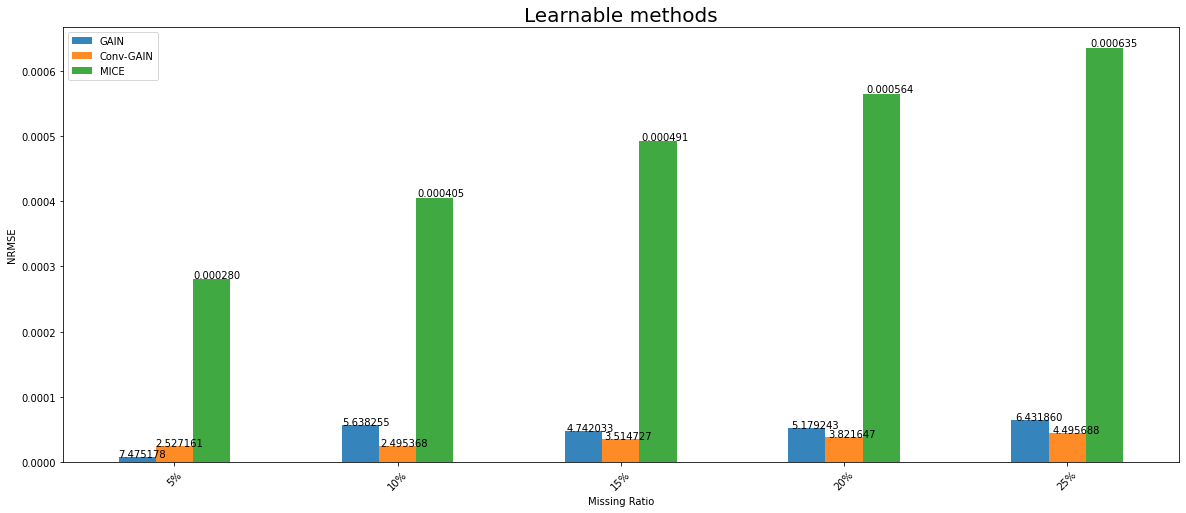

In [51]:
# Concatenate all results in one dataframe
ax = full_learn_results.T.sort_values(by='5%').T.plot(kind='bar', rot=45, alpha=0.9, figsize=(20,8));
ax.set_title('Learnable methods', fontsize=20)
ax.set_xlabel('Missing Ratio')
ax.set_ylabel('NRMSE');
for p in ax.patches:
    ax.annotate(str(str(p.get_height())[:8]), (p.get_x()* 1.005, p.get_height()* 1.005))

##  All results

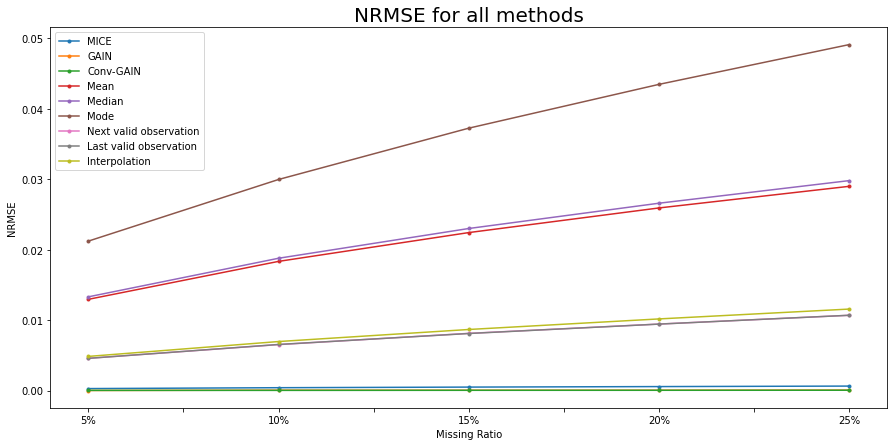

In [52]:
full_results = full_learn_results.join(full_results)
ax = full_results.plot(kind='line', figsize=(15, 7), style='.-')
ax.set_title('NRMSE for all methods', fontsize=20)
ax.set_xlabel('Missing Ratio')
ax.set_ylabel('NRMSE');

### Let's use Conv-GAIN Model to impute the whole data
- The shape of data is very large.
- We will apply the Conv-GAIN to the the data as a **sliding imputation window** with shape (25,25) slides over the whole data.

In [57]:
def full_data_imputaion(full_data:np.ndarray, square_length:int, conv_gain_parameters:dict):
    
    # check if the full data can be divided on squares each has the shape (square_length, square_length).
    if ((full_data.shape[1]%square_length) and (full_data.shape[2]%square_length)) != 0:
        raise(Exception('Expected a square length value so that full data can be divided into number of squares all have the same square length'))
    
    # create a new imputed data
    full_data_imputed = full_data.copy()

    # iterate over the all squares ===> 16 squares each square is (25, 25) (16*25*25=100*100 = 10000 pixels)
    for i in range(0, 4):
        for j in range(0, 4):
            print('Square : ({}, {})'.format(i, j))
            # get the imputed data
            temp = Conv_GAIN(full_data_imputed[:, i*square_length:i*square_length+square_length,\
                                               j*square_length:j*square_length+square_length],
                             conv_gain_parameters)
            # replace the origina data with the imputed data from the model 
            full_data_imputed[:,\
                              i*square_length:i*square_length+square_length,\
                              j*square_length:j*square_length+square_length] = temp
            
            # show an example from each model 
            idx = np.random.randint(1, len(full_data))
            plt.figure(figsize=(10,5))
            plt.subplot(1,2,1)
            plt.subplot(1,2,1).set_title('Original', fontsize=16)
            plt.imshow(full_data[idx, i*square_length:i*square_length+square_length,\
                                 j*square_length:j*square_length+square_length])
            plt.subplot(1,2,2)
            plt.subplot(1,2,2).set_title('Imputed', fontsize=16)
            plt.imshow(temp[idx]);
            plt.show()
            
    return full_data_imputed

Square : (0, 0)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:23<00:00,  1.67it/s]


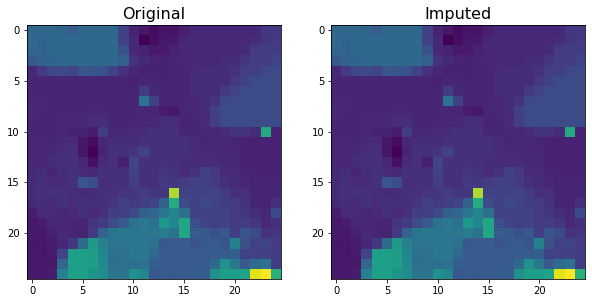

Square : (0, 1)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:18<00:00,  1.76it/s]


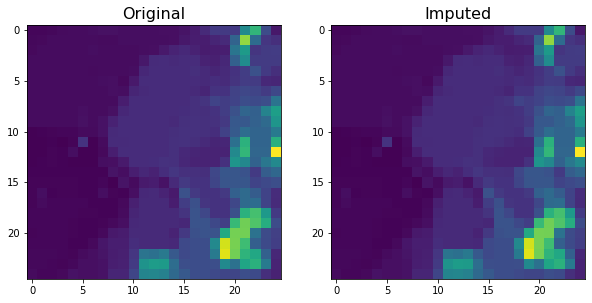

Square : (0, 2)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:19<00:00,  1.74it/s]


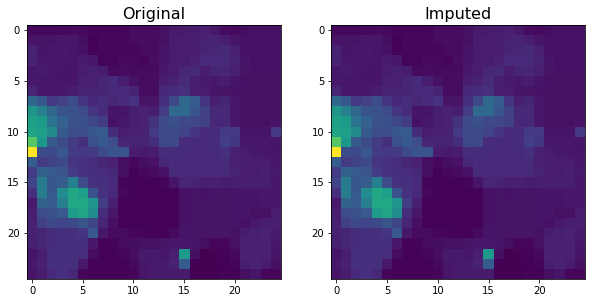

Square : (0, 3)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:20<00:00,  1.74it/s]


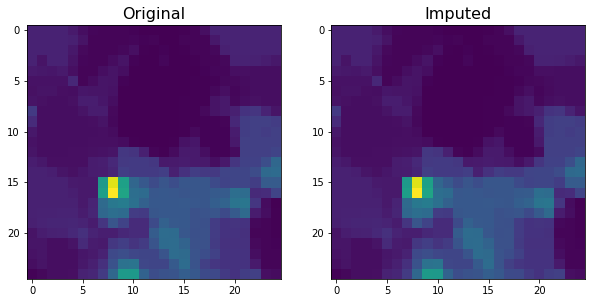

Square : (1, 0)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:19<00:00,  1.74it/s]


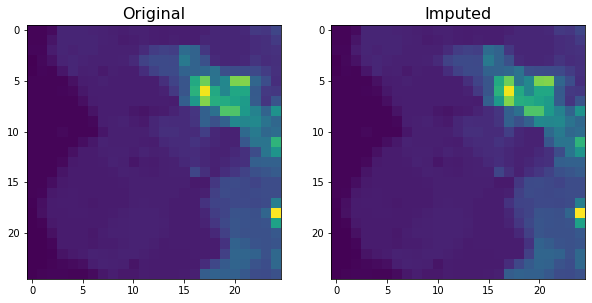

Square : (1, 1)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:26<00:00,  1.61it/s]


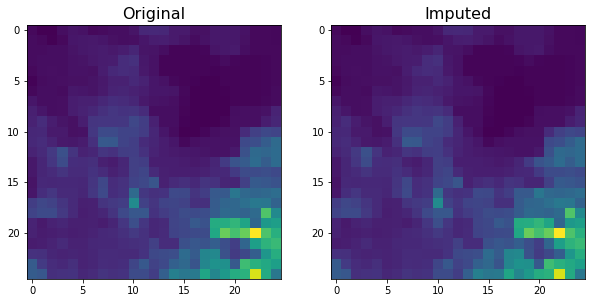

Square : (1, 2)


Epoch(1): D_loss, G_loss ===> 0.039, -0.000: 100%|███████████████████████████████████| 139/139 [01:26<00:00,  1.61it/s]


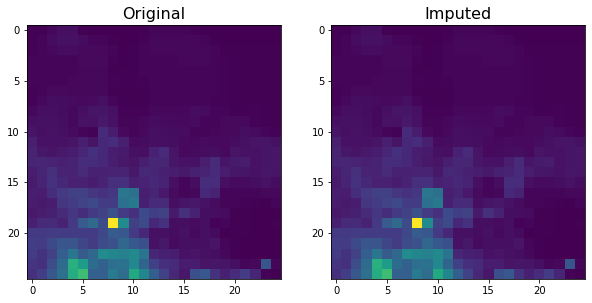

Square : (1, 3)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:19<00:00,  1.74it/s]


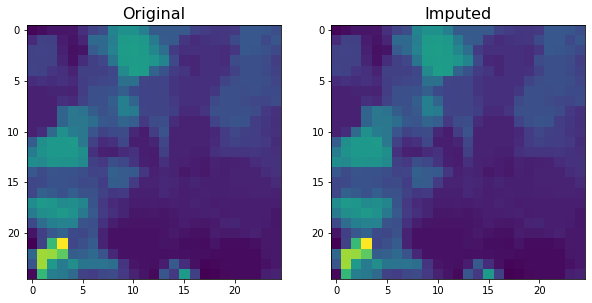

Square : (2, 0)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:21<00:00,  1.71it/s]


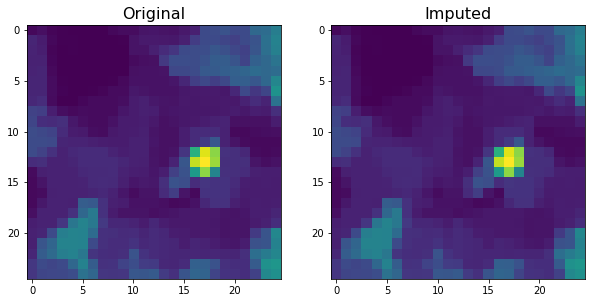

Square : (2, 1)


Epoch(1): D_loss, G_loss ===> 0.041, 0.037: 100%|████████████████████████████████████| 139/139 [01:21<00:00,  1.70it/s]


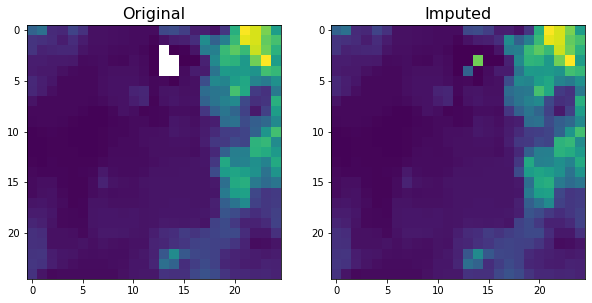

Square : (2, 2)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:24<00:00,  1.65it/s]


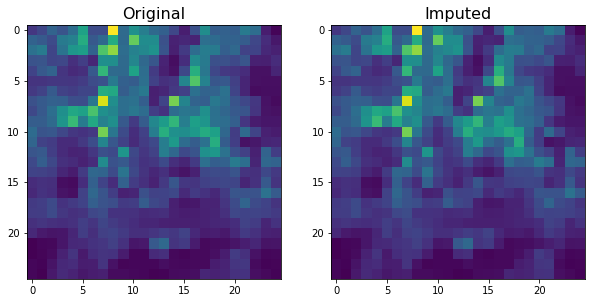

Square : (2, 3)


Epoch(1): D_loss, G_loss ===> 0.003, -0.000: 100%|███████████████████████████████████| 139/139 [01:24<00:00,  1.65it/s]


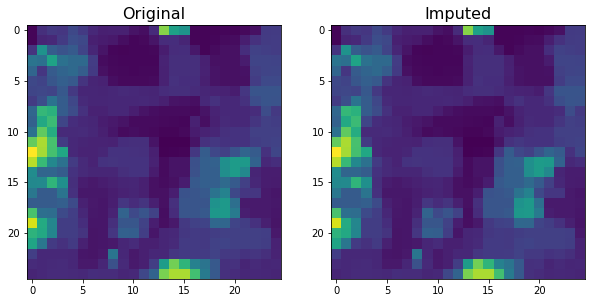

Square : (3, 0)


Epoch(1): D_loss, G_loss ===> 0.001, -0.000: 100%|███████████████████████████████████| 139/139 [01:26<00:00,  1.61it/s]


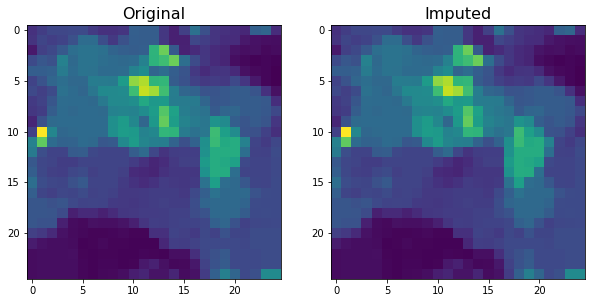

Square : (3, 1)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:20<00:00,  1.72it/s]


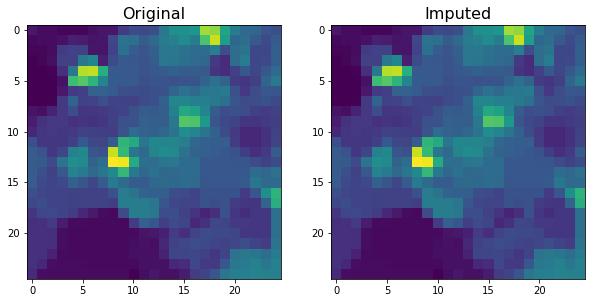

Square : (3, 2)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:25<00:00,  1.62it/s]


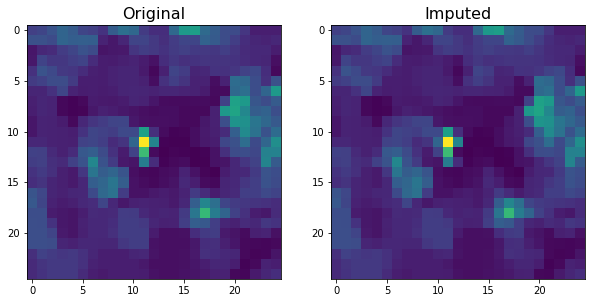

Square : (3, 3)


Epoch(1): D_loss, G_loss ===> -0.000, -0.000: 100%|██████████████████████████████████| 139/139 [01:23<00:00,  1.66it/s]


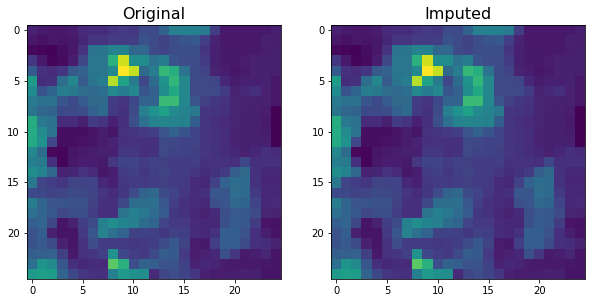

In [58]:
# define the model's hyperparameters
# impute the data by dividing it to 25x25 squares, and then impute each square separately.
conv_gain_parameters = {'batch_size':64,
                        'hint_rate':0.1,
                        'learning_rate':0.001,
                        'alpha':0.005,
                        'iterations':1}

full_data_imputed = full_data_imputaion(full_data=full_data, 
                                        square_length=25, 
                                        conv_gain_parameters=conv_gain_parameters)

In [59]:
# Check NaNs
print(f'Number of NaN values is : {np.isnan(full_data_imputed).max()*1}')

Number of NaN values is : 0


In [ ]:
# save the imputed data
np.save("full_data_imputed.npy", full_data_imputed)

In [60]:
full_data_imputed.shape

(8928, 100, 100, 1)

### Let's Animate the traffic of all grids through all time steps

In [61]:
import matplotlib.animation as animation
from IPython.display import HTML
import matplotlib.pyplot as plt

# create plt figure
fig = plt.figure()
# extract all frames (one each time step)
frames = [full_data_imputed[i,...] for i in range(full_data_imputed.shape[0])]
ims = []

# append all frames in animated plt
for idx, frame in enumerate(frames[:1000]):
    im = plt.imshow(frame, animated=True)
    ims.append([im]);

ani = animation.ArtistAnimation(fig, ims, interval=60, blit=True, repeat_delay=1000)

ani.save('images/animation.gif')

In [63]:
from IPython.core.display import display, HTML

display(HTML('<img align="center" height="800" width="800" src="images/animation.gif">'))